In [ ]:
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html
!pip install matplotlib scikit-learn timm tqdm

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
import numpy as np
import torch
import itertools
import pickle
import torch
from torch.utils.data import DataLoader
import timm
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import itertools


In [5]:
# Load datasets from pkl files
with open('./split_data/train_dataset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
with open('./split_data/val_dataset.pkl', 'rb') as f:
    val_dataset = pickle.load(f)
with open('./split_data/test_dataset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "vit_large_patch16_224"

model = timm.create_model(model_name, pretrained=True)

# Collect all labels from the training dataset
num_classes = torch.cat([labels for _, labels in train_loader], dim=0)

# Determine the number of unique labels (classes)
num_classes = len(torch.unique(num_classes))


# Adjust the head of the model for your specific number of classes (e.g., number of mushroom types)
model.head = torch.nn.Linear(in_features=model.head.in_features, out_features=num_classes)

print(f'model : {model_name}')
print(f'class num : {num_classes}')


model.load_state_dict(torch.load('./model_save/mushroom_vit_large_patch16_224_3.pth'))

Number of classes: 215
model : vit_large_patch16_224
class num : 215


<All keys matched successfully>

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [25]:
def evaluate_model(loader, title, num_classes):
    model.eval()
    y_true = []
    y_scores = []

    # Collect labels and model outputs
    with torch.no_grad():
        for data in tqdm(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_scores.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Binarize the labels for ROC and PR curve calculations
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    # Calculate total accuracy
    accuracy = np.mean(y_true == np.argmax(y_scores, axis=1))
    accuracy_label = f'Total Accuracy: {accuracy * 100:.2f}%'

    # ROC Curve and AUC
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2)  # Removed label
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(title=accuracy_label, loc="lower right")  # Include accuracy in legend title
    plt.show()

    # Precision-Recall curve
    precision, recall, average_precision = dict(), dict(), dict()
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_scores[:, i])

    plt.figure()
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], lw=2)  # Removed label
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve - {title}')
    plt.legend(title=accuracy_label, loc="lower right")  # Include accuracy in legend title
    plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

c:\Users\SYH\anaconda3\envs\alpha\lib\site-packages\timm\models\vision_transformer.py:86: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:235.)
  x = F.scaled_dot_product_attention(
c:\Users\SYH\anaconda3\envs\alpha\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


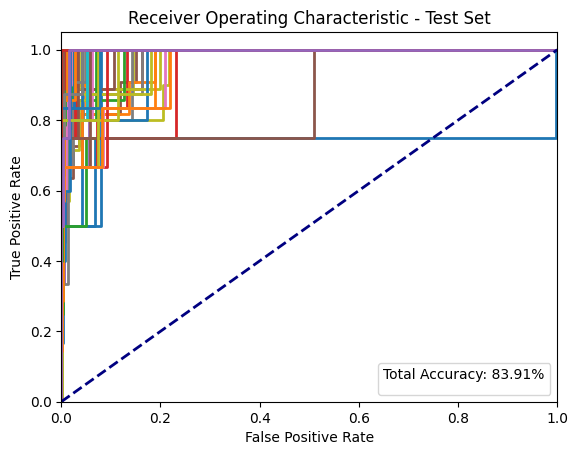

c:\Users\SYH\anaconda3\envs\alpha\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\SYH\anaconda3\envs\alpha\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


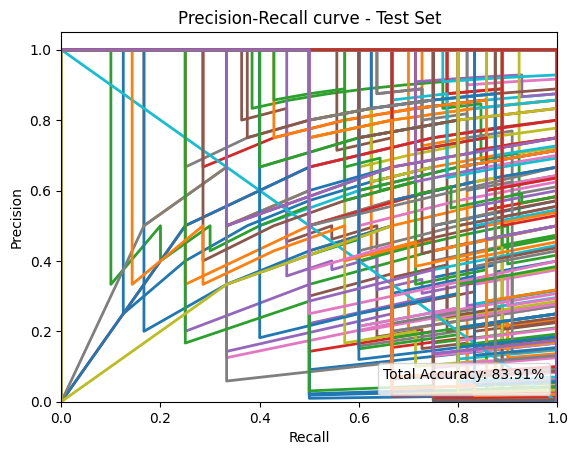

In [26]:
evaluate_model(test_loader, "Test Set", num_classes)